In [14]:
import cv2
from PIL import Image
import numpy as np
import uuid
import os
from tqdm import tqdm
import mediapipe as mp
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

In [2]:
df = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"/dataset/Video Information Extraction.csv")

In [3]:
df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,0,63047,39,13,248,192,wheelchair
11976,25,-1,1,8,12,aslsearch,train,http://www.aslsearch.com/signs/videos/wheelcha...,0,63050,163,62,625,400,wheelchair
11977,25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186,76,17,236,240,whistle
11978,25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188,68,14,212,192,whistle


### First of all, for a simple use case, only the N most represented  words will be used.

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

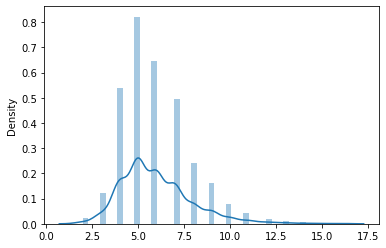

In [4]:
word_freq = dict(df["gloss"].value_counts())
freq = np.array(list(word_freq.values()))

sns.distplot(freq)

In [5]:
print("By taking only word that appears more than 9 times, " + str(len(freq[freq >= 9])) + "will remain ("+str(len(freq[freq < 9])/len(freq))+"% of videos neglected)" )

By taking only word that appears more than 9 times, 204will remain (0.898% of videos neglected)


In [6]:
kept_gloss = list(word_freq.keys())[:np.where(freq < 9)[0][0]]
new_df = df[df["gloss"].isin(kept_gloss)]

In [7]:
new_df = new_df.sort_values(by='video_id')

In [8]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
558,25,-1,1,4,32,signschool,val,https://signstock.blob.core.windows.net/signsc...,0,626,485,85,1608,1080,accident
559,25,-1,1,5,6,signschool,val,https://signstock.blob.core.windows.net/signsc...,1,627,662,54,1434,1080,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/what.mp4,1,69531,155,34,1067,720,what
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


### Collect videos as images sequence

#### Open a video with open CV

In [9]:
video_path = os.path.dirname(os.path.dirname(os.getcwd()))+"\\dataset\\videos\\"
id_video = 1652

In [10]:
cap = cv2.VideoCapture(video_path + str(df["video_id"][id_video]).zfill(5)+".mp4")
frame_count = 1

frame_start = df["frame_start"][id_video]
frame_end =  df["frame_end"][id_video]
x1,y1,x2,y2 = df["bbox_xmin"][id_video], df["bbox_ymin"][id_video], df["bbox_xmax"][id_video], df["bbox_ymax"][id_video]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret :
        if (frame_count >= frame_start) and ((frame_end == -1) or (frame_end >= frame_count)):
            cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),2)
        cv2.imshow('frame',frame)
    else:
        break
    frame_count += 1
    if cv2.waitKey(20) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## Detect handpose on a single video

In [15]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh

In [16]:
hand_position = []
cap = cv2.VideoCapture("dataset/videos/00414.mp4")
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.5) as hands: 
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.7) as face_mesh:
        while cap.isOpened():
            ret, frame = cap.read()

            if ret:

                # Flip on horizontal
                image = cv2.flip(frame, 1)

                # Set flag
                image.flags.writeable = False

                # Detections
                hand_results = hands.process(image)
                face_results = face_mesh.process(image)
                
                if hand_results.multi_handedness:
                    print(hand_results.multi_handedness)

                # Set flag to true
                image.flags.writeable = True

                # Rendering results
                
                #Detect hands position
                if hand_results.multi_hand_landmarks:
                    # At least one hand has been detected
                    temp_hand_position = []
                    for num, hand in enumerate(hand_results.multi_hand_landmarks):
                        mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS, 
                                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                                mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                                 )
                    hand_position.append(hand_results.multi_hand_landmarks)

                    #Detect face position
                    if face_results.multi_face_landmarks:
                        #Face has been detected
                        temp_face_position = []
                        for face_landmarks in face_results.multi_face_landmarks:
                            mp_drawing.draw_landmarks(
                              image,
                              landmark_list=face_landmarks,
                              connections=mp_face_mesh.FACEMESH_TESSELATION,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles
                              .get_default_face_mesh_tesselation_style())

                            mp_drawing.draw_landmarks(
                              image,
                              landmark_list=face_landmarks,
                              connections=mp_face_mesh.FACEMESH_CONTOURS,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles
                              .get_default_face_mesh_contours_style())
                            mp_drawing.draw_landmarks(
                              image,
                              landmark_list=face_landmarks,
                              connections=mp_face_mesh.FACEMESH_IRISES,
                              landmark_drawing_spec=None,
                              connection_drawing_spec=mp_drawing_styles
                              .get_default_face_mesh_iris_connections_style())
                        temp_face_position.append(face_results.multi_face_landmarks[0])

                # Showing our image    
                cv2.imshow('Hand and Face Tracking', image)
            else :
                break

            if cv2.waitKey(50) & 0xFF == ord('q'):
                break

cap.release()
cv2.destroyAllWindows()

### Get the first coordinate from the first recognized hand placement. Each tracked hand is composed of 21 reference points characterized by 3 coordinates: x, y (2D coordinates) and z (depth).

In [23]:
def get_coordinate_from_landmark(landmark):
    ''' Extract 3D coordinates of a landmark'''
    return np.array([[landmark.x, landmark.y, landmark.z]])

def get_positions_from_track(tracks, handness=None):
    
    ''' Return a vector of length 42 linked to the 21 landmarks of each hand. 
        If a hand has not been recognized, landmarks 2D positions values are -1 by default
    '''
    # Notation : first 21 landmarks linked to left hand and the last 21 landmarks linked to right hand
    if handness:
        if len(handness) == 1:
            #A single hand has been tracked
            label = handness[0].classification[0].label
            simulated_hands = - np.ones(shape=(21, 3))
            all_positions = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[0].landmark], axis = 0)
            if label == "Left":
                all_positions = np.concatenate((all_positions, simulated_hands), axis = 0)
            else:
                all_positions = np.concatenate((simulated_hands, all_positions), axis = 0)
        else:
            # Two hands has been detected
            label = handness[0].classification[0].label
            
            first_hand = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[0].landmark], axis = 0)
            second_hand = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[1].landmark], axis = 0)
            if label == "Left":
                all_positions = np.concatenate((first_hand, second_hand), axis = 0)
            else:
                all_positions = np.concatenate((second_hand, first_hand), axis = 0)

    else:
        all_positions = np.concatenate([get_coordinate_from_landmark(landmark) for landmark in tracks[0].landmark], axis = 0)
    return all_positions

def get_all_tracked_hand(finename_video):
    
    hand_position = []
    face_position = []
    cap = cv2.VideoCapture(finename_video)
    with mp_hands.Hands(min_detection_confidence=0.6, min_tracking_confidence=0.5) as hands: 
        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.6) as face_mesh:
            while cap.isOpened():
                ret, frame = cap.read()

                if ret:

                    # Flip on horizontal
                    image = cv2.flip(frame, 1)

                    # Set flag
                    image.flags.writeable = False

                    # Detections
                    hand_results = hands.process(image)
                    face_results = face_mesh.process(image)

                    if hand_results.multi_hand_landmarks:
                        # Hands has been recognized
                        handness = hand_results.multi_handedness
                                          
                        hand_position.append(get_positions_from_track(hand_results.multi_hand_landmarks, handness))
                        
                        if face_results.multi_face_landmarks:
                            #Face has been recognized
                            face_position.append(get_positions_from_track(face_results.multi_face_landmarks))
                        else:
                            face_position.append(-np.ones(shape = (478,3)))
                else :
                    break

    cap.release()
    
    hand_position = np.array(hand_position)
    face_position = np.array(face_position)
    if len(hand_position) != 0:
        all_position = np.concatenate((hand_position, face_position), axis = 1)
    else :
        all_position = []
    return all_position

In [24]:
track_record = {}
for video_id in tqdm(new_df["video_id"]):
    track_record[video_id] = get_all_tracked_hand(video_path + str(video_id).zfill(5)+".mp4")

100%|████████████████████████████████████████████████████████████████████████████| 2060/2060 [1:53:07<00:00,  3.29s/it]


#### Analysing sequence length

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


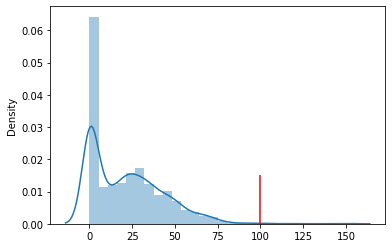

In [25]:
len_sequence_video= np.array([len(seq) for seq in track_record.values()])
sns.distplot(len_sequence_video)
plt.vlines(100, 0, 0.015, 'r')

In [26]:
min_number_sequence = 20

In [31]:
video_id_kept = np.array(list(track_record.keys()))[np.where(len_sequence_video > min_number_sequence)[0]]

In [33]:
new_df2 = new_df[new_df["video_id"].isin(video_id_kept)]

In [34]:
new_df2

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
560,25,-1,1,6,6,signschool,train,https://signstock.blob.core.windows.net/signsc...,1,628,677,98,1386,1080,accident
561,25,-1,1,7,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14661...,0,629,69,23,613,480,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/what.mp4,1,69531,155,34,1067,720,what
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

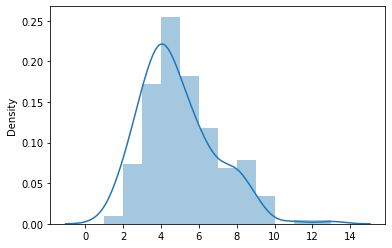

In [41]:
word_freq = dict(new_df2["gloss"].value_counts())
freq = np.array(list(word_freq.values()))

sns.distplot(freq)

In [42]:
print("By taking only word that appears more than 5 times, " + str(len(freq[freq >= 5])) + " will remain ("+str(len(freq[freq < 5])/len(freq))+"% of videos neglected)" )

By taking only word that appears more than 5 times, 100 will remain (0.5098039215686274% of videos neglected)


In [43]:
kept_gloss = list(word_freq.keys())[:np.where(freq < 5)[0][0]]
final_df = new_df2[new_df2["gloss"].isin(kept_gloss)]

In [44]:
final_df = final_df.sort_values(by='video_id')

In [69]:
final_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
560,25,-1,1,6,6,signschool,train,https://signstock.blob.core.windows.net/signsc...,1,628,677,98,1386,1080,accident
561,25,-1,1,7,13,asldeafined,train,https://media.asldeafined.com/vocabulary/14661...,0,629,69,23,613,480,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,25,-1,1,1,115,aslbrick,train,http://aslbricks.org/New/ASL-Videos/tiger.mp4,0,69510,331,34,1000,720,tiger
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


## Construct all videos with the same number of sequence

Has it will be feed to a deep neural network, we need to have a fixed number of sequence for each record. To do that, a linear interpolation.

In [46]:
number_of_sequences = 64

In [49]:
masks = np.zeros((len(track_record), number_of_sequences), dtype = "bool")

In [50]:
masks.shape

(2060, 64)

In [63]:
clean_record = []
for count, track_id in tqdm(enumerate(list(final_df['video_id']))):
    track = track_record[track_id]
    nb_seq = track.shape[0]
    if number_of_sequences < nb_seq:
        idx = np.linspace(0, nb_seq-1, number_of_sequences, dtype = int)
        masks[count] = 1
        features = np.take(track, idx, axis = 0)
    else:
        masks[count,:nb_seq] = 1
        features = np.concatenate((track, np.zeros((number_of_sequences - nb_seq, 520, 3), dtype = np.short)), axis = 0)

    if features.shape != (number_of_sequences, 520, 3):
        print("Problem")
        break    
    clean_record.append(features)

642it [00:00, 2670.33it/s]


In [64]:
clean_record = np.array(clean_record)

In [65]:
clean_record.shape

(642, 64, 520, 3)

In [70]:
joblib.dump(clean_record, 'features.pkl', compress = 3)
joblib.dump(masks, 'masks.pkl', compress = 3)
final_df.to_csv('dataframe.csv')

In [67]:
reduced_encoder = OneHotEncoder(handle_unknown='ignore')
reduced_encoder.fit(np.array(list(final_df["gloss"])).reshape(-1,1))

reduced_le = LabelEncoder()
reduced_le.fit(np.array(list(final_df["gloss"])))

LabelEncoder()

In [68]:
pickle.dump(reduced_encoder, open("reduced one hot encoder", 'wb'))
pickle.dump(reduced_le, open("reduced label encoder", 'wb'))